# Подготовка

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

from drive.MyDrive.kursach import helpers
path = 'drive/MyDrive/kursach/'

Mounted at /content/drive/


In [2]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 88 kB 3.6 MB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
     |████████████████████████████████| 376 kB 31.7 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=991bce4c8f7e26d5021a6ac9c7289eab0ae93c6ea010dd956049080d74e7e7ba
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=cd598d431659d8d498d61119ef909f7b1156778f311c991d812a09e138e7d8e4
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 102 kB 6.7 MB/s 
     |████████████████████████████████| 47.6 MB 2.2 MB/s 
albumentations==1.1.0 is successfully installed


In [4]:
import albumentations as albu
import copy
import cv2
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import segmentation_models_pytorch as smp
from sklearn import model_selection
import torch
from torch import nn
from torch.utils import data

In [5]:
rand = 51
np.random.seed(rand)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
im_medseg, mk_medseg, im_radio, mk_radio = helpers.load_datasets(path, size=(256, 256))

Added drive/MyDrive/kursach/raw-data-kaggle/images_medseg.npy, shape (1, 100, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/masks_medseg.npy, shape (4, 100, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/images_radiopedia.npy, shape (1, 829, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/masks_radiopedia.npy, shape (4, 829, 256, 256)


In [9]:
gc.collect()

184

# Основные классы и функции

In [51]:
class Dataset(data.Dataset):
    def __init__(self, X, y, augmentations=None):
        self.X = X.reshape(-1, 1, X.shape[1], X.shape[2]).astype(np.float32)
        self.y = y
        self.augmentations = augmentations

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, i):
        x_el, y_el = self.X[i], self.y[i]
        if self.augmentations is not None:
          sample = self.augmentations(image=x_el[0], mask=y_el)
          x_el[0], y_el = sample['image'], sample['mask']

        x_el = torch.from_numpy(x_el).to(device)
        y_el = torch.from_numpy(y_el.astype(np.int64)).to(device)

        return x_el, y_el

def get_loader(dataset, batch=64):
  return data.DataLoader(dataset, batch_size=batch)

def prepare_datasets(X, y):
  X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, random_state=rand)
  train = Dataset(X_train, y_train, train_transform)
  test = Dataset(X_test, y_test, test_transform)
  return train, test

In [11]:
class Network:
    def __init__(self, model, loss):
        self.model = model.to(device)
        self.loss = loss
        self.optim = torch.optim.Adam(self.model.parameters())
        self.loss_history = []

    def fit(self, data, epochs=50, verbose=False):
      data = get_loader(data)
      for i in range(epochs):
        total_loss = 0
        for X, y in data:
          pred = self.model(X)
          loss = self.loss(pred, y)
          total_loss += loss.detach().to('cpu').item()

          self.optim.zero_grad()
          loss.backward()
          self.optim.step()

        if verbose:
          print(f'Epoch {i}, loss {total_loss}')
        self.loss_history.append(total_loss)

    def fit_best(self, train, epochs=50, test_metric='accuracy', test_args=(),
                 train_ratio=0.8, reshuffle_iter=3, no_improvements_iter=5):
      size = len(train)
      lengths = [int(size * train_ratio), size - int(size * train_ratio)]
      best_model = None
      best_score = 0.
      no_improvements = 0

      for i in range(epochs):
        print(f'Epoch {i}')
        if i % reshuffle_iter == 0:
          cur_train, cur_test = torch.utils.data.random_split(train, lengths)
        # train phase
        self.fit(cur_train, epochs=1)
        # test phase
        score = self.test(cur_test, test_metric, *test_args)
        if score > best_score:
          best_score = score
          best_model = copy.deepcopy(self.model)
          print(f'Improved score: {best_score}')
          no_improvements = 0
        else:
          no_improvements += 1

        if no_improvements >= no_improvements_iter:
          break

      self.model = best_model


    def test(self, data, metric, *args):
      data = get_loader(data)
      size = len(data.dataset)
      num_batches = len(data)
      total_metric = 0.

      with torch.no_grad():
        for X, y in data:
          pred = self.model(X).argmax(1)
          if metric == 'accuracy':
            total_metric += self._accuracy(pred, y)
          elif metric == 'iou':
            total_metric += self._iou(pred, y, args[0])

      if metric == 'accuracy':
        total_metric /= size
      elif metric == 'iou':
        total_metric /= num_batches

      return total_metric

    def _accuracy(self, y_pred, y_true):
      im_size = y_pred.shape[1] * y_pred.shape[2]
      return (y_pred == y_true).type(torch.float).sum().item() / im_size

    def _iou(self, y_pred, y_true, class_label):
      y_pred = y_pred == class_label
      y_true = y_true == class_label
      intersection = y_pred & y_true
      union = y_pred | y_true
      return intersection.type(torch.float).sum().item() / union.type(torch.float).sum().item()

In [12]:
def create_network(n_classes):
  return Network(smp.Unet(in_channels=1, classes=n_classes, activation='softmax'),
                 nn.CrossEntropyLoss())

# Аугментации

Horizontal Flip, Constant Border -> очень плохо

In [135]:
train_transform = albu.Compose([
    albu.VerticalFlip(p=0.5),

    albu.ShiftScaleRotate(rotate_limit=5, shift_limit=0.05, scale_limit=0.001,
                              p=1, border_mode=cv2.BORDER_REPLICATE),

    #albu.PadIfNeeded(min_height=256, min_width=256, always_apply=True,
    #                 border_mode=cv2.BORDER_REPLICATE),
    #albu.RandomCrop(height=256, width=256, always_apply=True),

    #albu.Normalize(mean=0, std=1),
    #albu.ToGray(p=1),
    #albu.CLAHE(p=0.5),
    #albu.RandomBrightness(p=1)
    #albu.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=1),           
])

test_transform = None

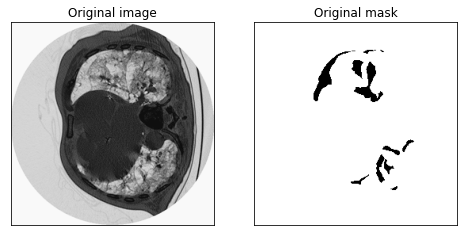

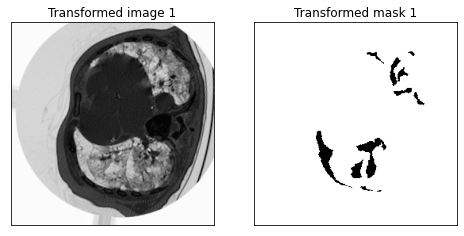

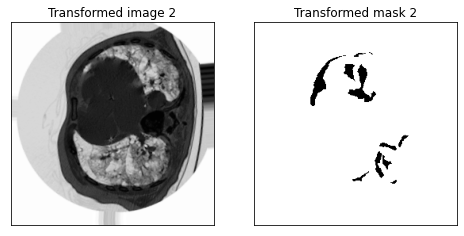

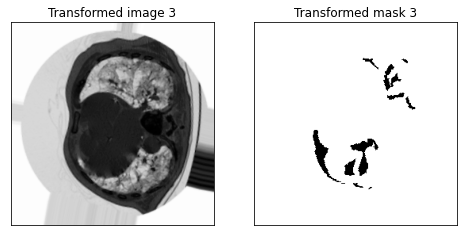

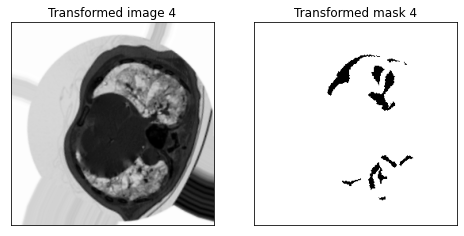

In [126]:
# Visualize transformations
X = im_medseg[0, 0].reshape((1, 256, 256))
y = mk_medseg[0, 0].reshape((1, 256, 256))
dataset = Dataset(X, y, train_transform)

helpers.show_im_row(np.vstack((X, y)), size=4,
                    titles=['Original image', 'Original mask'])

for i in range(4):
  x_el, y_el = dataset[0]
  x_el, y_el = x_el.cpu().numpy(), y_el.cpu().numpy()
  helpers.show_im_row(np.vstack((x_el, y_el.reshape(1, 256, 256))), size=4,
                      titles=[f'Transformed image {i+1}', f'Transformed mask {i+1}'])

# Классифицируем по четырем классам

In [136]:
X = np.concatenate((im_medseg[0], im_radio[0]), axis=0)
y = np.concatenate((mk_medseg, mk_radio), axis=1)
y = y.argmax(0)
X.shape, y.shape

((929, 256, 256), (929, 256, 256))

In [137]:
train, test = prepare_datasets(X, y)
model = create_network(4)

In [138]:
model.fit(train, epochs=20, verbose=True)

Epoch 0, loss 12.700916945934296
Epoch 1, loss 10.82871013879776
Epoch 2, loss 10.411065697669983
Epoch 3, loss 10.282972753047943
Epoch 4, loss 10.182222425937653
Epoch 5, loss 10.1138876080513
Epoch 6, loss 10.088220655918121
Epoch 7, loss 10.079103887081146
Epoch 8, loss 10.058043003082275
Epoch 9, loss 10.04274433851242
Epoch 10, loss 10.028456270694733
Epoch 11, loss 10.013674259185791
Epoch 12, loss 9.983285784721375
Epoch 13, loss 10.013133525848389
Epoch 14, loss 10.013093411922455
Epoch 15, loss 10.000619530677795
Epoch 16, loss 10.005245864391327
Epoch 17, loss 10.014824509620667
Epoch 18, loss 9.991879940032959
Epoch 19, loss 10.012566566467285


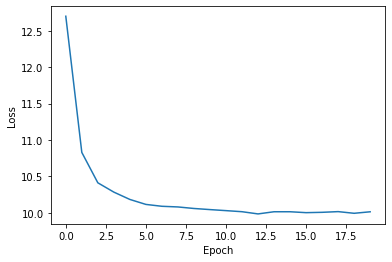

In [139]:
helpers.plot_loss(model)

In [140]:
model.test(test, 'accuracy')

0.9298126056630124

In [141]:
for i in range(4):
  print(helpers.LABELS[i], 'IoU:', model.test(test, 'iou', i))

Ground Glass IoU: 0.0
Consolidation IoU: 0.0
Lungs Other IoU: 0.6595106976275601
Background IoU: 0.9293946245690442


Видим, что модель научилась хорошо находить самые "простые" классы - легкие и фон. А вот с классами, которые нас интересуют больше всего, имеются проблемы.

In [142]:
label_pairs = [('True ' + label, 'Predicted ' + label)
               for label in helpers.LABELS]
# flatten label pairs
labels = [label for pair in label_pairs for label in pair]

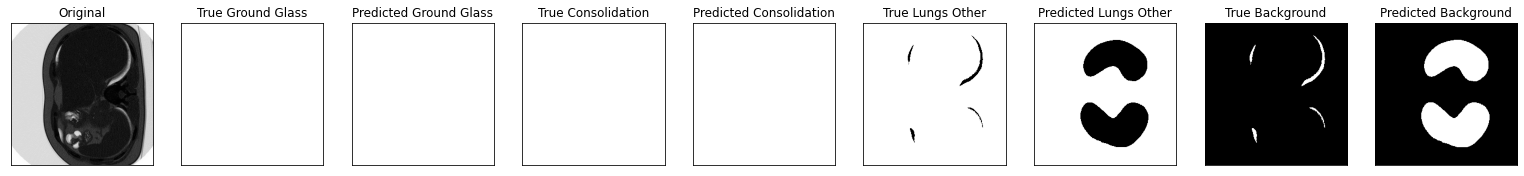

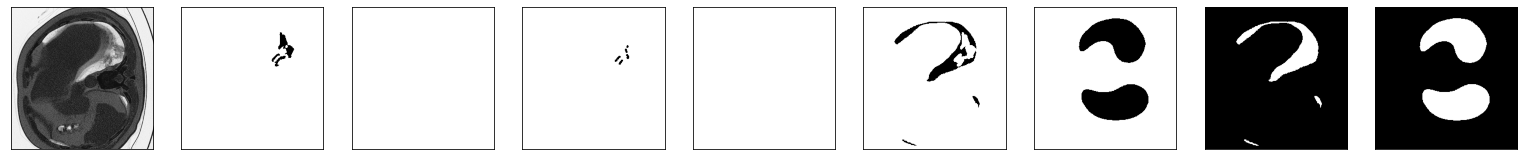

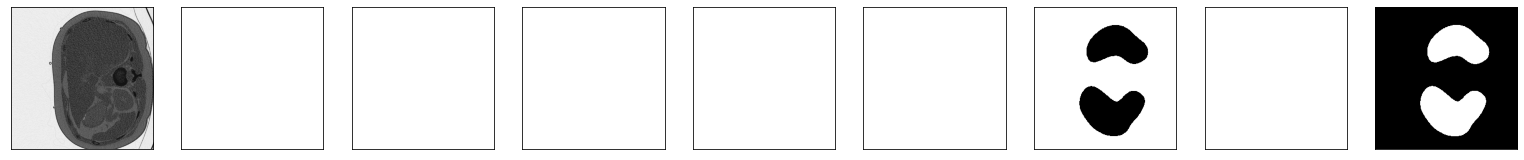

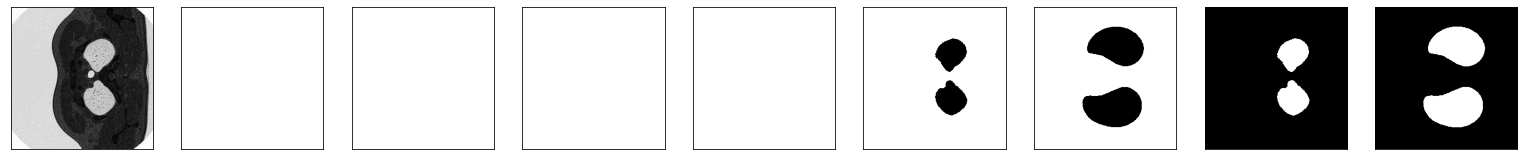

In [143]:
for i in range(4):
  sample, true_answer = test[i]
  pred_answer = model.model(sample.reshape(1, 1, sample.shape[1], -1)).argmax(1)
  images = [sample[0]]
  for j in range(4):
    images += [true_answer == j, (pred_answer == j)[0]]
  images = [im.cpu().detach().numpy() for im in images]
  titles = ['Original'] + labels if i == 0 else None
  helpers.show_im_row(np.array(images), size=3, titles=titles)